In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier, cv, Pool

In [2]:
train = pd.read_csv('Data/Amazon Employee Access Data/train.csv')
train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [3]:
train.shape

(32769, 10)

In [4]:
test = pd.read_csv('Data/Amazon Employee Access Data/test.csv')
test.head()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,4,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,5,42093,50015,117961,118343,119598,118422,300136,118424,118425


In [5]:
test.shape

(58921, 10)

In [6]:
test.drop(columns='id',inplace=True)

### Exploratory Data Analysis

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [8]:
train.nunique()

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

In [9]:
sum(train.isnull().sum())

0

In [10]:
train['ACTION'].value_counts()

1    30872
0     1897
Name: ACTION, dtype: int64

**Data is unbalanced**

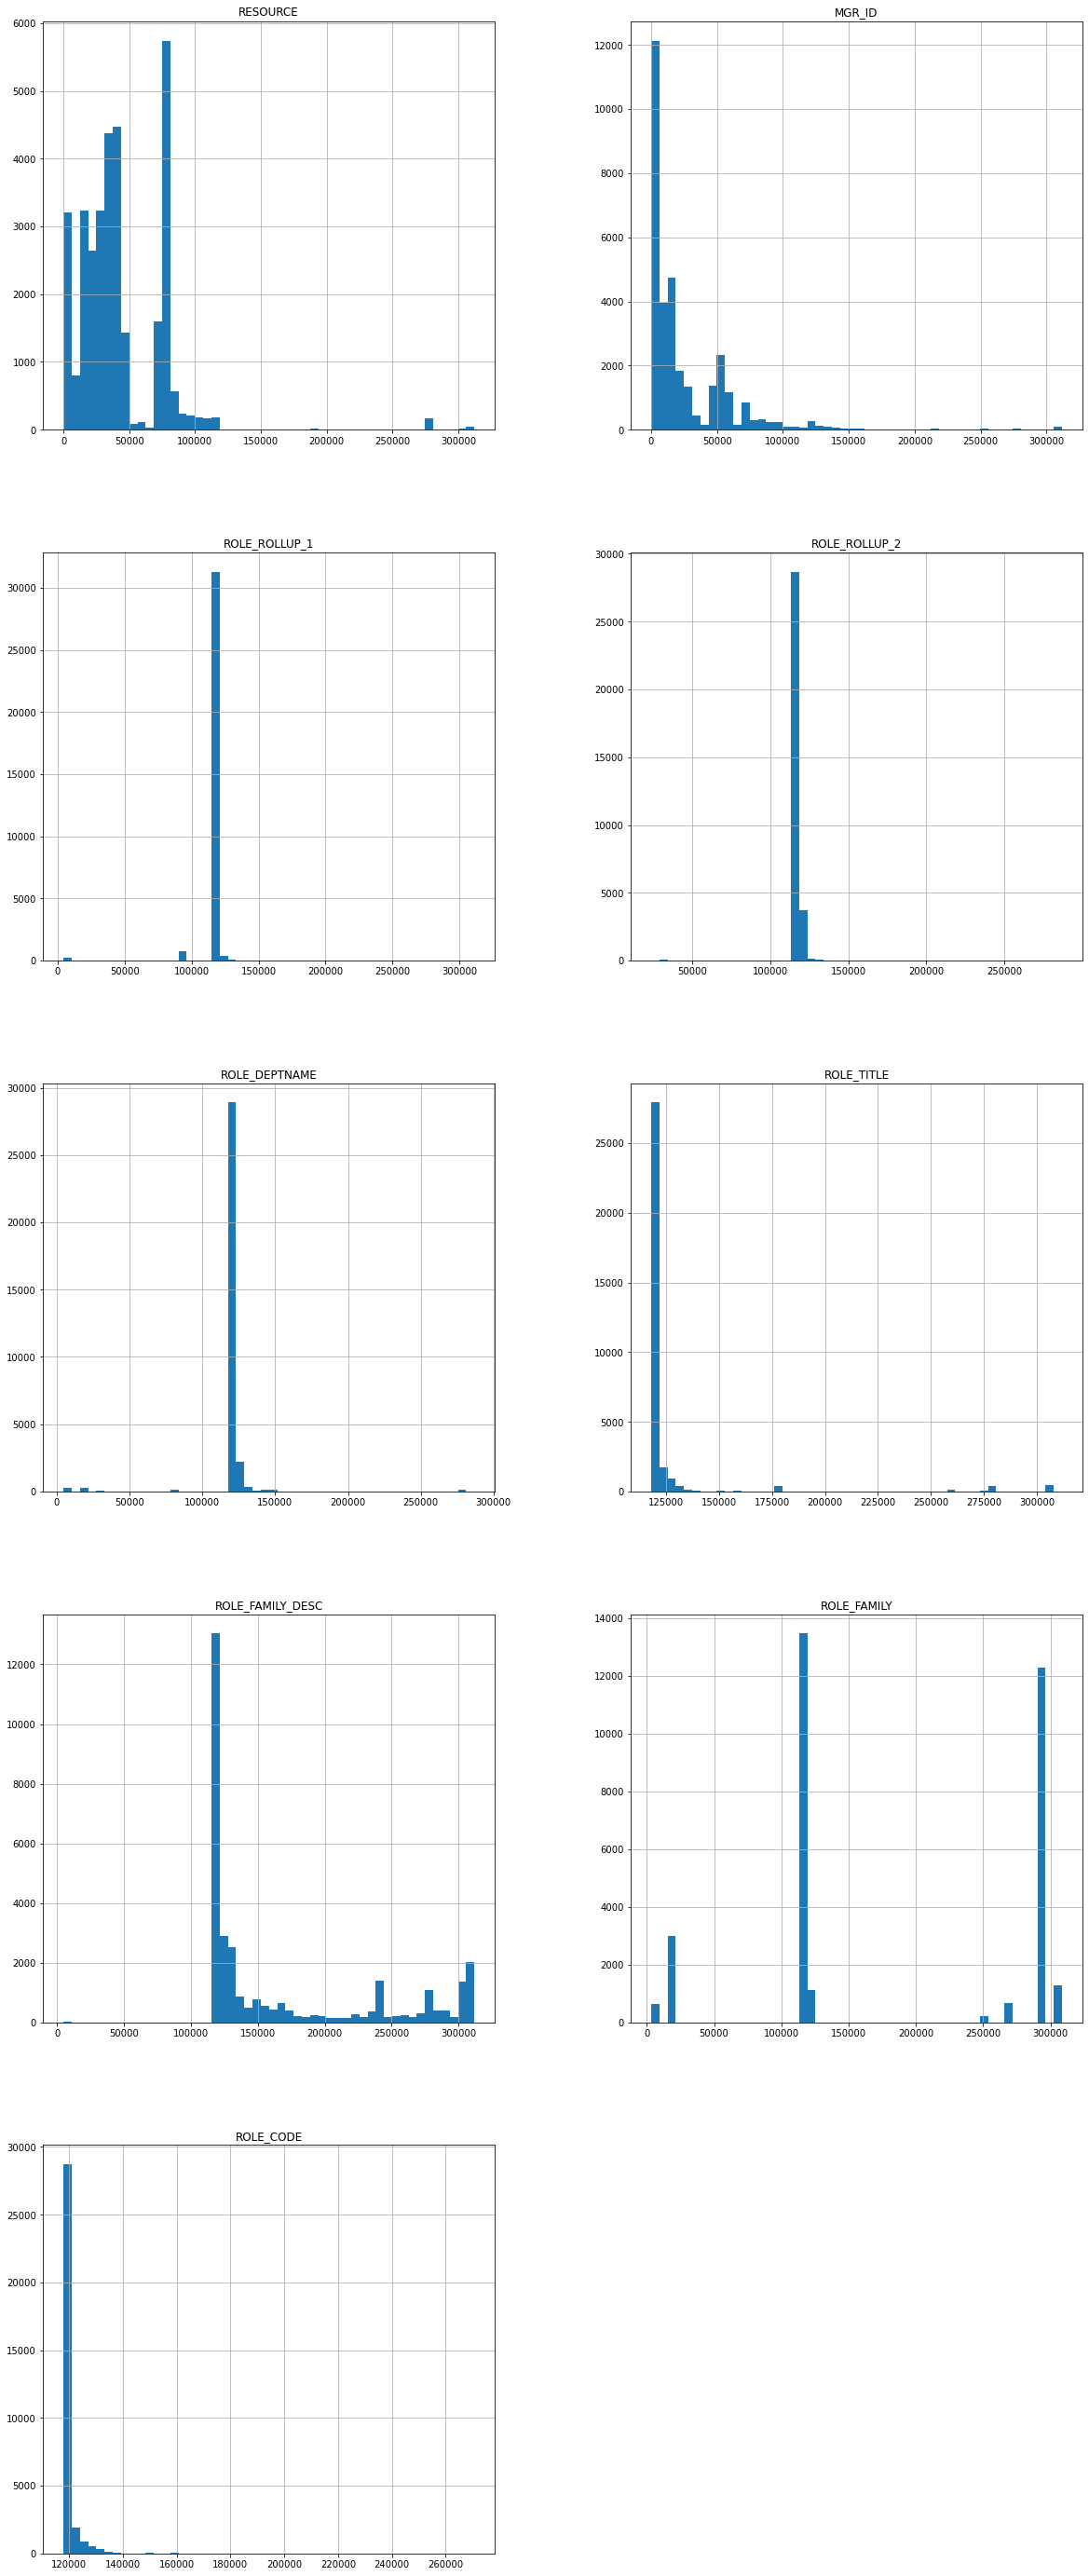

In [11]:
train.drop(columns='ACTION').hist(figsize=(20,50),bins=50,layout=(5,2));

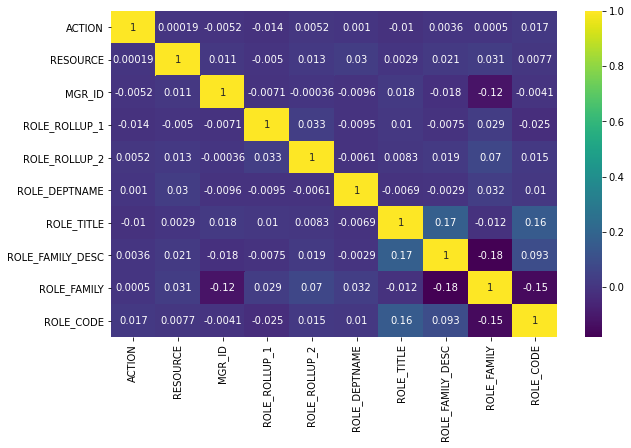

In [12]:
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(),cmap='viridis',annot=True);

## Model Building

### 1. On unbalanced data

In [13]:
X = train.drop(columns='ACTION')
y = train['ACTION']

**Logisitic Regression**

In [14]:
encoder = OneHotEncoder(drop='first')

In [15]:
x = encoder.fit_transform(X)

In [16]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25, random_state = 1)

In [17]:
classifier = LogisticRegression(solver='liblinear')

In [18]:
classifier.fit(x_train,y_train)

LogisticRegression(solver='liblinear')

In [19]:
classifier.score(x_train,y_train)

0.9594319661458334

In [20]:
classifier.score(x_val,y_val)

0.9473941169290858

**CatBoost Classifier**

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state = 1)

In [22]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose':20,
          'random_seed':1
         }

In [23]:
catmodel1 = CatBoostClassifier(**params)
catmodel1.fit(X_train,y_train, eval_set = (X_val,y_val), use_best_model=True)

Learning rate set to 0.069882
0:	test: 0.5400959	best: 0.5400959 (0)	total: 207ms	remaining: 3m 26s
20:	test: 0.7053957	best: 0.7053957 (20)	total: 484ms	remaining: 22.5s
40:	test: 0.7363684	best: 0.7363684 (40)	total: 750ms	remaining: 17.5s
60:	test: 0.7565725	best: 0.7565725 (60)	total: 1.03s	remaining: 15.8s
80:	test: 0.7658212	best: 0.7658986 (79)	total: 1.28s	remaining: 14.5s
100:	test: 0.7767405	best: 0.7767405 (100)	total: 1.52s	remaining: 13.5s
120:	test: 0.7859988	best: 0.7859988 (120)	total: 1.75s	remaining: 12.7s
140:	test: 0.7913205	best: 0.7913205 (140)	total: 2s	remaining: 12.2s
160:	test: 0.7970506	best: 0.7970506 (160)	total: 2.23s	remaining: 11.6s
180:	test: 0.7995461	best: 0.7997747 (178)	total: 2.47s	remaining: 11.2s
200:	test: 0.8016667	best: 0.8017826 (196)	total: 2.73s	remaining: 10.8s
220:	test: 0.8068215	best: 0.8068215 (220)	total: 3s	remaining: 10.6s
240:	test: 0.8095411	best: 0.8095411 (240)	total: 3.28s	remaining: 10.3s
260:	test: 0.8114352	best: 0.8114352 (

In the above model Catboost treated Categorical Data as Numerical Data

In [24]:
categorical_features = list(range(X.shape[1]))
print(categorical_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [25]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose':100,
          'random_seed':1,
          'cat_features':categorical_features
         }

In [26]:
catmodel2 = CatBoostClassifier(**params)
catmodel2.fit(X_train,y_train, eval_set = (X_val,y_val), use_best_model=True)

Learning rate set to 0.069882
0:	test: 0.5637606	best: 0.5637606 (0)	total: 60.8ms	remaining: 1m
100:	test: 0.8912516	best: 0.8912516 (100)	total: 5.97s	remaining: 53.2s
200:	test: 0.8959353	best: 0.8959406 (199)	total: 14.1s	remaining: 56.2s
300:	test: 0.8980247	best: 0.8982812 (288)	total: 20.2s	remaining: 46.9s
400:	test: 0.8988575	best: 0.8992987 (362)	total: 26.9s	remaining: 40.2s
500:	test: 0.8999874	best: 0.8999874 (500)	total: 33.3s	remaining: 33.2s
600:	test: 0.9004275	best: 0.9005535 (598)	total: 41.5s	remaining: 27.5s
700:	test: 0.9000595	best: 0.9008243 (655)	total: 51.1s	remaining: 21.8s
800:	test: 0.8995177	best: 0.9008243 (655)	total: 58.5s	remaining: 14.5s
900:	test: 0.9005697	best: 0.9008243 (655)	total: 1m 5s	remaining: 7.2s
999:	test: 0.9002576	best: 0.9008243 (655)	total: 1m 11s	remaining: 0us

bestTest = 0.9008242549
bestIteration = 655

Shrink model to first 656 iterations.


### Cross Validation

In [27]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose':100,
          'random_seed':1,
         }

# pool for data processing
total_train_data = Pool(data=X,label=y,cat_features=categorical_features)

scores = cv(pool=total_train_data, params=params,fold_count=4,seed=1,shuffle=True,stratified=True)

0:	test: 0.5381441	best: 0.5381441 (0)	total: 441ms	remaining: 7m 20s
100:	test: 0.8758526	best: 0.8758526 (100)	total: 55.7s	remaining: 8m 16s
200:	test: 0.8842819	best: 0.8842819 (200)	total: 1m 42s	remaining: 6m 46s
300:	test: 0.8865232	best: 0.8865232 (300)	total: 2m 26s	remaining: 5m 40s
400:	test: 0.8887667	best: 0.8887796 (399)	total: 3m 14s	remaining: 4m 50s
500:	test: 0.8896627	best: 0.8896987 (495)	total: 4m 4s	remaining: 4m 3s
600:	test: 0.8901047	best: 0.8901349 (596)	total: 5m 1s	remaining: 3m 19s
700:	test: 0.8906707	best: 0.8906809 (697)	total: 5m 52s	remaining: 2m 30s
800:	test: 0.8912613	best: 0.8912854 (799)	total: 6m 42s	remaining: 1m 40s
900:	test: 0.8915761	best: 0.8915761 (900)	total: 7m 31s	remaining: 49.6s
999:	test: 0.8920316	best: 0.8920727 (996)	total: 8m 18s	remaining: 0us


**Feature Importance**

In [28]:
feature_imp = catmodel2.get_feature_importance(prettified=True)
feature_imp

,Feature Id,Importances
0,RESOURCE,19.922997
1,ROLE_DEPTNAME,16.731695
2,MGR_ID,15.050018
3,ROLE_ROLLUP_2,13.304811
4,ROLE_FAMILY_DESC,9.594347
5,ROLE_TITLE,7.346093
6,ROLE_FAMILY,6.363669
7,ROLE_ROLLUP_1,6.023152
8,ROLE_CODE,5.663218


Text(0.5, 1.0, 'Feature Importance')

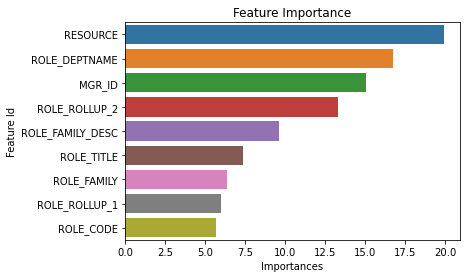

In [29]:
sns.barplot(x='Importances',y='Feature Id', data=feature_imp)
plt.title('Feature Importance')

In [30]:
catmodel2.score(X_val,y_val)

0.9555718296106432

In [31]:
predictions = catmodel2.predict(test)
predictions

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

### 2. Balanced data

In [32]:
sm = SMOTE(random_state=27)
X_bal,y_bal = sm.fit_sample(X,y)

In [33]:
y_bal.value_counts()

1    30872
0    30872
Name: ACTION, dtype: int64

**Logisitic Regression**

In [34]:
encoder = OneHotEncoder(drop='first')

In [35]:
x_bal = encoder.fit_transform(X_bal)

In [36]:
x_train, x_val, y_train, y_val = train_test_split(x_bal, y_bal, test_size=0.25, random_state = 1)

In [37]:
classifier = LogisticRegression(solver='liblinear')

In [38]:
classifier.fit(x_train,y_train)

LogisticRegression(solver='liblinear')

In [39]:
classifier.score(x_train,y_train)

0.9765483285825344

In [40]:
classifier.score(x_val,y_val)

0.9578258616221819

**CatBoost Classifier**

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X_bal, y_bal, test_size=0.25, random_state = 1)

In [42]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose':100,
          'random_seed':1,
          'cat_features':categorical_features
         }

In [43]:
catmodel_bal = CatBoostClassifier(**params)
catmodel_bal.fit(X_train,y_train, eval_set = (X_val,y_val), use_best_model=True)

Learning rate set to 0.08172
0:	test: 0.9399464	best: 0.9399464 (0)	total: 80.6ms	remaining: 1m 20s
100:	test: 0.9921443	best: 0.9921443 (100)	total: 15.2s	remaining: 2m 15s
200:	test: 0.9927494	best: 0.9927494 (200)	total: 30.2s	remaining: 2m
300:	test: 0.9928372	best: 0.9928414 (293)	total: 45.6s	remaining: 1m 45s
400:	test: 0.9928921	best: 0.9929159 (354)	total: 1m 3s	remaining: 1m 34s
500:	test: 0.9929297	best: 0.9929606 (438)	total: 1m 19s	remaining: 1m 19s
600:	test: 0.9929932	best: 0.9930169 (566)	total: 1m 36s	remaining: 1m 3s
700:	test: 0.9929626	best: 0.9930225 (663)	total: 1m 51s	remaining: 47.6s
800:	test: 0.9929109	best: 0.9930225 (663)	total: 2m 6s	remaining: 31.4s
900:	test: 0.9928958	best: 0.9930225 (663)	total: 2m 19s	remaining: 15.3s
999:	test: 0.9928590	best: 0.9930225 (663)	total: 2m 35s	remaining: 0us

bestTest = 0.993022461
bestIteration = 663

Shrink model to first 664 iterations.


**Feature Importance**

In [44]:
feature_imp_bal = catmodel_bal.get_feature_importance(prettified=True)
feature_imp_bal

,Feature Id,Importances
0,ROLE_ROLLUP_2,20.988172
1,ROLE_DEPTNAME,18.101551
2,MGR_ID,12.059362
3,RESOURCE,11.709697
4,ROLE_ROLLUP_1,9.513394
5,ROLE_CODE,7.787905
6,ROLE_FAMILY_DESC,7.015441
7,ROLE_TITLE,6.766799
8,ROLE_FAMILY,6.057678


Text(0.5, 1.0, 'Feature Importance')

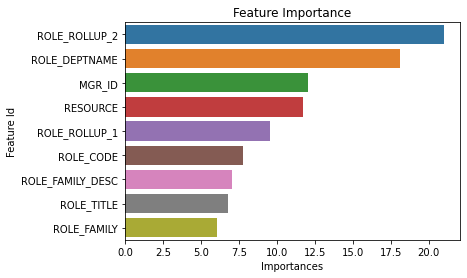

In [45]:
sns.barplot(x='Importances',y='Feature Id', data=feature_imp_bal)
plt.title('Feature Importance')

In [46]:
catmodel_bal.score(X_train,y_train)

0.9922043707350782

In [47]:
catmodel_bal.score(X_val,y_val)

0.9727260948432236

In [48]:
predictions_bal = catmodel_bal.predict(test)
predictions_bal

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

### 3. Using class weights

In [49]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose':100,
          'random_seed':1,
          'cat_features':categorical_features,
          'scale_pos_weight':1897/30872
         }
catmodel = CatBoostClassifier(**params)
catmodel.fit(X_train,y_train, eval_set = (X_val,y_val), use_best_model=True)

Learning rate set to 0.08172
0:	test: 0.7275227	best: 0.7275227 (0)	total: 75.8ms	remaining: 1m 15s
100:	test: 0.9910920	best: 0.9910920 (100)	total: 13.8s	remaining: 2m 3s
200:	test: 0.9914424	best: 0.9914499 (159)	total: 30.8s	remaining: 2m 2s
300:	test: 0.9918500	best: 0.9918500 (300)	total: 46.3s	remaining: 1m 47s
400:	test: 0.9919042	best: 0.9919139 (396)	total: 1m 5s	remaining: 1m 38s
500:	test: 0.9920011	best: 0.9920011 (500)	total: 1m 24s	remaining: 1m 23s
600:	test: 0.9921088	best: 0.9921102 (596)	total: 1m 42s	remaining: 1m 7s
700:	test: 0.9920717	best: 0.9921305 (615)	total: 1m 58s	remaining: 50.5s
800:	test: 0.9921192	best: 0.9921305 (615)	total: 2m 16s	remaining: 34s
900:	test: 0.9921944	best: 0.9922088 (854)	total: 2m 34s	remaining: 17s
999:	test: 0.9922772	best: 0.9922842 (969)	total: 2m 50s	remaining: 0us

bestTest = 0.9922842481
bestIteration = 969

Shrink model to first 970 iterations.


In [50]:
catmodel.score(X_train,y_train)

0.9850349831562581

In [51]:
catmodel.score(X_val,y_val)

0.959639803057787

In [52]:
predictions_cw = catmodel_bal.predict(test)
predictions_cw

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)